# Assignment 3: Creating a WordyPy Solver

You now understand the rules of _WordyPy_ and how to read the game state from an image. Now your job is to read in a
_WordyPy_ partial play and provide a next **good** guess. What's a good guess? A good guess is one which:

1. Continues to adhere to the rules of _WordPy_
2. Does not repeat words which have already been played
3. Uses the knowledge of previous guesses to pick a new good word

Unlike previous assignments there are no guardrails for this task -- you can complete this using whatever software
architecture you like! In addition, I've put my code in a new module for you to import, called `wordy`. You can just
import this module and begin making calls to it. You should be able to understand how it works by reading the module
documentation.


In [5]:
import wordy
import PIL
import pytesseract
import random

class Letter:
    """This is the letter class
    Attributes:
        letter: str
        in_correct_place: bool = False
        in_word: bool = False
        """
    def __init__(self, letter: str) -> None:
        self.letter = letter
        self.in_correct_place = False
        self.in_word = False
        
    def is_in_correct_place(self) -> bool:
        return self.in_correct_place
    
    def is_in_word(self) -> bool:
        return self.in_word
    def __str__(self):
        return self.letter
    
class Bot:
    '''Definition of the Bot class'''
    def __init__(self, word_list_file: str, display_spec) -> None:
        self.word_list =list(
            map(lambda x: x.strip().upper(), open(word_list_file, "r").readlines())
        )
        #print(f'initial data size: {len(self.word_list)}')
        self.display_spec = display_spec
        self.b_letter_lst = []
        self.expected = ['','','','','']
        self.new_lst = sorted(list(set(self.word_list)))
        self.debug = False
    
    def _tuple_to_str(self, pixels: tuple) -> str:
        result = '#'
        for val in pixels[0:3]:
            if len(hex(val)) < 4:
                result = result + '0' + hex(val).upper()[-1]
            else:
                result = result + hex(val).upper()[2:]
        return result
    
    def _process_image(self, guess: str, guess_image) -> list[Letter]:
        coordinate = (1,1)
        result = []
        block_interval = self.display_spec.block_width + self.display_spec.space_between_letters
        for i in range(5):
            
            letter = Letter(guess[i])
            color = self._tuple_to_str(guess_image.getpixel(coordinate))
            
            if color == self.display_spec.correct_location_color:
                letter.in_correct_place = True
                letter.in_word = True
            elif color == self.display_spec.incorrect_location_color:
                letter.in_correct_place = False
                letter.in_word = True
            elif color == self.display_spec.incorrect_color:
                letter.in_correct_place = False
                letter.in_word = False
            
            result.append(letter)
            coordinate = (coordinate[0] + block_interval, 1)
            
        return result
    
    def _word_is_not_banned(self, word: str, banned_letter: list):
        result = True
        for l in banned_letter:
            if l in word:
                result = False
        return result
    
    def _get_banned_letter_and_structure(self, guess_results):
        success_counter = 0
        for i,result in enumerate(guess_results):
            if not result.is_in_word() and result.letter not in self.b_letter_lst:
                self.b_letter_lst.append(result.letter)
            elif result.is_in_correct_place():
                self.expected[i] = result.letter
                success_counter += 1
                if success_counter == 5:
                    print('You have succeeded! Exit game.')
                    return 'Exit'
    
    def _letter_filter(self, lst: list, banned_letter: list):
        i=0
        while i<len(lst):
            wrd = lst[i]
            if not self._word_is_not_banned(wrd, banned_letter):
                lst.remove(wrd)
            else:
                i+=1
        
    def _structure_filter(self, lst, expected:list):
        i=0
        while i<len(lst):
            for j,l in enumerate(expected):
                wrd = lst[i]
                if l!='' and wrd[j]!=l:
                    lst.remove(wrd)
                    break
                elif j==4:
                    i+=1
        
    def make_guess(self) -> str:
        guess = random.choice(self.new_lst)
        print(f'guess: {guess}')
        return guess
    
    def record_guess_results(self, guess: str, guess_results) -> None:
        
        results_letter = self._process_image(guess, guess_results)
        
        if self._get_banned_letter_and_structure(results_letter) == 'Exit':
            return
        
        if(self.debug):
            print(f'''
            -----------------------
            banned_letters: {self.b_letter_lst}
            expected: {self.expected}
            ''')
            
        self._letter_filter(self.new_lst, self.b_letter_lst)
        
        if(self.debug):
            print(f'new list length after letter filter: {len(self.new_lst)}')
        
        self._structure_filter(self.new_lst, self.expected)
        
        if(self.debug):
            print(f'new list lenth after structure filter: {len(self.new_lst)}')
            if len(self.new_lst) < 20:
                print(f'''
                new_lst: {self.new_lst}
                ''')

def solution(board: PIL.Image) -> str:
    """The student solution to the problem.

    You must write code to query the wordy module and make
    a guess for the word. You needs to inspect the module to
    understand how to do this, and this function should only return
    the guess that you are going to make based on the game board state.

    Returns:
        str: The guess that you are going to make.
    """
    new_guess = "" 
    guessed_words = []
    # YOUR CODE HERE
    #raise NotImplementedError()
    guessed_wrds = []
    size = wordy.get_display_spec().block_height
    space = wordy.get_display_spec().space_between_letters
    num = int(board.height / wordy.get_display_spec().block_height)
    bot = Bot('words.txt', wordy.get_display_spec())
    
    def ocr_letter(img_in, r, c):
        coordinate = (c * (size + space), r * size, size + c * (size + space), size * (r + 1))
        
        image = img_in.copy().crop(coordinate).convert('L')
        threshold = 255
        new_image = bytearray(image.tobytes())
        for location, value in enumerate(new_image):
            if value < threshold:
                new_image[location] = 255
            else:
                new_image[location] = 0

        new_image = PIL.Image.frombytes(image.mode, image.size, bytes(new_image))
        config = '--psm 10 -c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ"'
        ocr_result = pytesseract.image_to_string(new_image, config = config)
        
        return ocr_result
    
    def ocr_board(board):
        for r in range(num):
            letters = []
            for c in range(5):
                scan_result = ocr_letter(board, r, c)
                #print(scan_result, r, c)

                if len(scan_result) > 2:
                    letters.append(scan_result[1])
                elif len(scan_result) > 0:
                    letters.append(scan_result[0])
                else:
                    letters.append('I')
            guessed_words.append(''.join(letters))

#------------------------- end of function definition -----------------------------#
    
    display(board)
    ocr_board(board)
    
    for i in range(num):
        guess = guessed_words[i]
        coordinate = (0, i * size, 4 * space + 5 * size, size * (i + 1))
        word_img = board.copy().crop(coordinate)
        
        #print('*' * 20)
        #display(word_img)
        
        bot.record_guess_results(guess, word_img)
        
    
    return bot.make_guess()

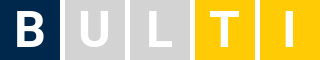

guess: BROSE


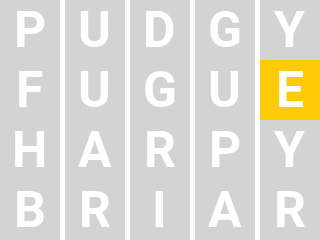

guess: WOMEN


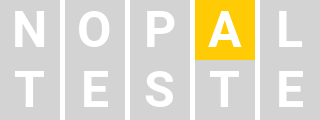

guess: RHUMB


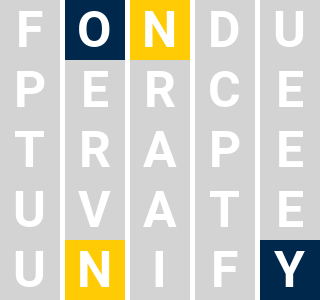

guess: MOONY


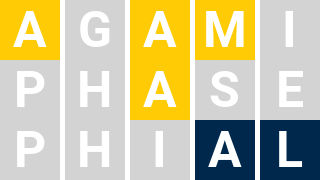

guess: MODAL


In [6]:
# The autograder for this assignment is easy, it will try and play
# a few rounds of the game and ensure that errors are not thrown. If
# you can make it through five rounds we'll assume you have the right
# solution!
#
# You SHOULD NOT change anything in the wordy module, instead you
# must figure out how to write the solution() function in this notebook
# to make a good guess based on the board state!

for i in range(5):
    try:
        # Get an image of the current board state from wordy.
        # Note that the image contains some number of random guesses (always less than 5 guesses).
        image = wordy.get_board_state()
        # Create a new *good* guess based on the image and rules of wordy
        new_guess = solution(image)  # your code goes in solution()!
        # Send that guess to wordy to make sure it doesn't throw any errors
        wordy.make_guess(new_guess)
    except Exception as e:
        raise e